In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class BayesNet:
    """This class was used for HW 2, some of the attributes/methods might not be used in the context of poker"""
    """Can probably not use this class at all with a few adjustments to other code"""
    ## Object representing the probability tables in a Bayes' Net.
    class ProbabilityTable:
    
        ## variables := a dictionary that maps variable names to a specific column number within the table
        ## table := a dictionary with lists as keys and probabilities as values
            ## The keys (lists) represent specific configurations of truth values for each variable
        def __init__(self, variables, table):
            self.variables = variables
            self.table = table

    def __init__(self, variables, probability_tables, graph, values):
        self.variables = variables
        self.probability_tables = probability_tables
        self.graph = graph
        self.indices = {v: k for k, v in self.variables.items()}
        self.values = values
        
        

In [3]:
def pf_sample(probabilities, values):
    """Sample a probability function defined by an array of 'probabilities' and 'values'"""
    total = 0
    partition = [None]*len(probabilities)
    for i in range(0,len(probabilities)):
        partition[i] = total + probabilities[i]
        total = total + probabilities[i]
        
    num = random.random()
    for i in range(0,len(partition)):
        if i == 0:
            if num <= partition[i]:
                return values[i]
        else:
            if num > partition[i-1] and num <= partition[i]:
                return values[i]

In [5]:
def generate_opponent_bet_table():
    """Generate a random opponent bet table, e.g. given a strength of 1, the probability it bets 10 might some random number"""
    ret = BayesNet.ProbabilityTable({'S': 0, 'B': 1}, {})
    
    for s in range(1,11):
        total = 0.0
        for b in range(1,11):
            ret.table[(s,b)] = random.random()
            total = total + ret.table[(s,b)]
        for b in range(1,11):
            ret.table[(s,b)] = ret.table[(s,b)]/total
    return ret

In [6]:
def generate_opponent_bet(opponent_strength, opponent_bet_table):
    """Given a hand strength for the opponent, generate a bet from the opponent given its bet table"""
    probabilities = [None]*10
    
    for b in range(1,11):
            probabilities[b-1] = opponent_bet_table.table[(opponent_strength,b)]
    
    return pf_sample(probabilities, [1,2,3,4,5,6,7,8,9,10])

In [7]:
def eu(action, my_strength, counts, opponent_bet):
    """Return the expected utility of an action given 'my_strength', 'counts' table, and 'opponent_bet' table"""
    if action == 'f':
        return -1
    else:
        total = 0
        for s in range(1,11):
            if sum(counts[:,opponent_bet-1]) == 0:
                continue
            if my_strength > s:
                total = total + (counts[s-1][opponent_bet-1]/sum(counts[:,opponent_bet-1]))*(1+opponent_bet)
            elif my_strength < s:
                total = total + (counts[s-1][opponent_bet-1]/sum(counts[:,opponent_bet-1]))*-1*(1+opponent_bet)
            else:
                total = total + (counts[s-1][opponent_bet-1]/sum(counts[:,opponent_bet-1]))*0 # no utility for tie game
        return total
        

In [8]:
def action(my_strength, counts, opponent_bet):
    """Return an action (fold (f) or call (c)) that maximizes expected utility"""
    if eu('f', my_strength, counts, opponent_bet) >= eu('c', my_strength, counts, opponent_bet):
        return 'f'
    else:
        return 'c'

In [4]:
# Each of the probabilities for each of the possible poker hands, e.g., hand_probabilities[9] := Pr(Royal flush)
hand_probabilities = [0.501177, 0.422569, 0.047539, 0.021128, 0.003925, 0.001965, 0.001441, 0.000240, 0.0000139, 0.00000154]

# Strength of each possible poker hand, e.g., hand_values[9] := strength of 10
hand_values = [1,2,3,4,5,6,7,8,9,10]

In [9]:
# 10 x 10 array representing the joint occurences of the opponent hand strength (1-10) and bet (1-10)
# Used to compute conditional P(Strength of opponent | Bet of opponent)
counts = np.zeros((10,10))

In [10]:
# Randomly generated opponent_bet table. Contains probabilities of opponent betting X given his hand strength Y
opponent_bet = generate_opponent_bet_table()

In [11]:
def game(counts, opponent_bet_table):
    """Method that simulates a single game between our agent and an opponent with a predefined 'opponent_bet_table'"""
    opponent_hand = pf_sample(hand_probabilities, hand_values)
    my_hand = pf_sample(hand_probabilities, hand_values)
    
    opponent_bet = generate_opponent_bet(opponent_hand, opponent_bet_table)
    my_action = action(my_hand, counts, opponent_bet)
    
#     a = eu('f', my_hand, counts, opponent_bet)
#     b = eu('c', my_hand, counts, opponent_bet)

#     print(my_hand, ' ', opponent_hand)
    counts[opponent_hand-1][opponent_bet-1] = counts[opponent_hand-1][opponent_bet-1] + 1
    if my_hand > opponent_hand:
        if my_action == 'c':
#             print(my_action, ' win')
            return (0,0, 1 + opponent_bet) # Call and win (good)
        else:
#             print(my_action, ' lose')
            return (0,1, -1) # Fold and lose (bad)
    elif my_hand < opponent_hand:
        if my_action == 'c':
#             print(my_action, ' lose')
            return (1,0, -1-opponent_bet) # Call and lose (bad)
        else:
#             print(my_action, ' lose')
            return (1,1, -1) # Fold and lose (good)
    else:
        if my_action == 'c':
#             print(my_action, ' tie')
            return (0,2,0) # Call and tie (neutral)
        else:
#             print(my_action, ' lose')
            return (1,2,-1) # Fold and tie (bad)

In [12]:
# 2 x 3 array summarizing results
# results[0][0] := # of times agent called and won
# results[0][1] := # of times agent fold and won (but actually lost due to folding)
# results[0][2] := # of times agent called and tied
# results[1][0] := # of times agent call and lost
# results[1][1] := # of times agent fold and lost
# results[1][2] := # of times agent fold and tied
results = [[0,0,0],[0,0,0]]


In [13]:
# Profit we make
money = 0

In [14]:
x = [i for i in range(0,10000)] # axis for # of games played
y = [0 for i in range(0,10000)] # axis for money

In [15]:
# Play 10000 games and store stats in 'results' array and update 'money'
for i in range(0,10000):
    res = game(counts, opponent_bet)
    results[res[0]][res[1]] = results[res[0]][res[1]] + 1
    money = money + res[2]
    y[i] = money

In [16]:
results

[[2813, 14, 2036], [499, 2289, 2349]]

In [17]:
money

9218

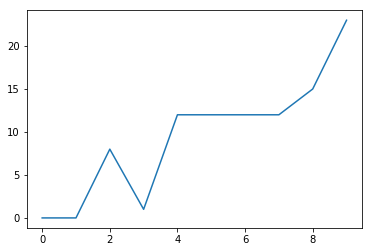

In [18]:
plt.plot(x[0:10],y[0:10])
plt.show() # money over time for 10 games

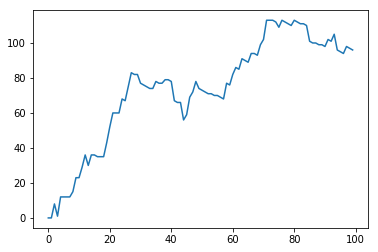

In [19]:
plt.plot(x[0:100],y[0:100])
plt.show() # money over time for 100 games

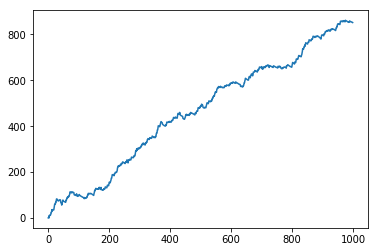

In [20]:
plt.plot(x[0:1000],y[0:1000])
plt.show() # money over time for 1000 games

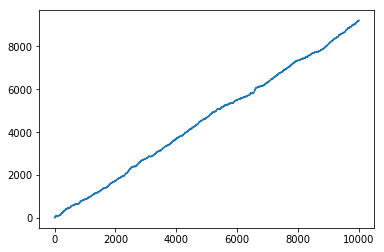

In [21]:
plt.plot(x[0:10000],y[0:10000])
plt.show() # money over time for 10000 games